In [1]:
import sys
sys.path.insert(0,"/home/albert7a/lib/python")


## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import time
from dask.diagnostics import ProgressBar
from datetime import date
import json
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def plot_bias_from_jsonfile(jsonfile,ax1,ax2,season):
    
    print jsonfile

    sourcefile=open(jsonfile,'rU')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)
    print nb_profilesEN4

    vert_standart=[0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]


    all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))

    def get_netcdf_profiles(jsonfile,infos,prof):
        list_profiles = infos.keys()
        reference_profile = str(list_profiles[prof])
        
        namezone=jsonfile[0:-5]
        dirname="/media/extra/DATA/EN4/profiles_files/"+namezone
        netcdf_name=dirname+"/profiles_EN4-"+reference_profile[1:]+"_NATL60-CJM165_TS.nc"
        dsprof=xr.open_dataset(netcdf_name)

        depth_en4=dsprof['depth_en4']
        depth_model=dsprof['depth_model']
        temp_en4=dsprof['temp_profileEN4']
        salt_en4=dsprof['salt_profileEN4']
        mean_temp_model=dsprof['mean_temp_model']
        mean_salt_model=dsprof['mean_salt_model']
        percent10_temp_model=dsprof['percent10_temp_model']
        percent10_salt_model=dsprof['percent10_salt_model']
        percent90_temp_model=dsprof['percent90_temp_model']
        percent90_salt_model=dsprof['percent90_salt_model']



        return depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model

    def project_standart_vertical_levels(depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model,vert_standart):

        temp_en4_standart=np.zeros(len(vert_standart))
        salt_en4_standart=np.zeros(len(vert_standart))
        mean_temp_model_standart=np.zeros(len(vert_standart))
        mean_salt_model_standart=np.zeros(len(vert_standart))
        percent10_temp_model_standart=np.zeros(len(vert_standart))
        percent10_salt_model_standart=np.zeros(len(vert_standart))
        percent90_temp_model_standart=np.zeros(len(vert_standart))
        percent90_salt_model_standart=np.zeros(len(vert_standart))

        for k in np.arange(len(vert_standart)-1):
            zs1=vert_standart[k]
            zs2=vert_standart[k+1]
            zs=(zs1+zs2)/2.
            idz=np.where(np.abs(depth_en4-zs)==np.min(np.abs(depth_en4-zs)))
            idz0=np.min(idz[0])
            if (idz0==0) | (idz0==len(depth_en4)-1):
                temp_en4_standart[k]='nan'
                salt_en4_standart[k]='nan'
                mean_temp_model_standart[k]='nan'
                mean_salt_model_standart[k]='nan'
                percent10_temp_model_standart[k]='nan'
                percent10_salt_model_standart[k]='nan'
                percent90_temp_model_standart[k]='nan'
                percent90_salt_model_standart[k]='nan'
            else:
                if depth_en4[idz0] < zs:
                    temp_en4_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * temp_en4[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * temp_en4[idz0+1]
                    salt_en4_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * salt_en4[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * salt_en4[idz0+1]
                    mean_temp_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_temp_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_temp_model[idz0+1]
                    mean_salt_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_salt_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * mean_salt_model[idz0+1]
                    percent10_temp_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_temp_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_temp_model[idz0+1]
                    percent10_salt_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_salt_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent10_salt_model[idz0+1]
                    percent90_temp_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_temp_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_temp_model[idz0+1]
                    percent90_salt_model_standart[k]=(1 - (zs-depth_en4[idz0])/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_salt_model[idz0] + (1 - (depth_en4[idz0+1] - zs)/(depth_en4[idz0+1]-depth_en4[idz0])) * percent90_salt_model[idz0+1]
                    
                if depth_en4[idz0] > zs:
                    temp_en4_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * temp_en4[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * temp_en4[idz0]
                    salt_en4_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * salt_en4[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * salt_en4[idz0]
                    mean_temp_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_temp_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_temp_model[idz0]
                    mean_salt_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_salt_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * mean_salt_model[idz0]
                    percent10_temp_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_temp_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_temp_model[idz0]
                    percent10_salt_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_salt_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent10_salt_model[idz0]
                    percent90_temp_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_temp_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_temp_model[idz0]
                    percent90_salt_model_standart[k]=(1 - (zs-depth_en4[idz0-1])/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_salt_model[idz0-1] + (1 - (depth_en4[idz0] - zs)/(depth_en4[idz0]-depth_en4[idz0-1])) * percent90_salt_model[idz0]



        return temp_en4_standart,salt_en4_standart,mean_temp_model_standart,mean_salt_model_standart,percent10_temp_model_standart,percent10_salt_model_standart,percent90_temp_model_standart,percent90_salt_model_standart


    
    all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))

    for prof in np.arange(nb_profilesEN4):
        depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model = get_netcdf_profiles(jsonfile,infos,prof)
        if depth_en4[-1] > 500:
            temp_en4_standart,salt_en4_standart,mean_temp_model_standart,mean_salt_model_standart,percent10_temp_model_standart,percent10_salt_model_standart,percent90_temp_model_standart,percent90_salt_model_standart = project_standart_vertical_levels(depth_en4,depth_model,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model,vert_standart)
            all_temp_mean_model[prof,:]=mean_temp_model_standart[:]
            all_salt_mean_model[prof,:]=mean_salt_model_standart[:]
            all_temp_en4[prof,:]=temp_en4_standart[:]
            all_salt_en4[prof,:]=salt_en4_standart[:]
            all_temp_percent10_model[prof,:]=percent10_temp_model_standart[:]
            all_salt_percent10_model[prof,:]=percent10_salt_model_standart[:]
            all_temp_percent90_model[prof,:]=percent90_temp_model_standart[:]
            all_salt_percent90_model[prof,:]=percent90_salt_model_standart[:]

    all_temp_mean_model[all_temp_mean_model==0.]='nan'
    all_salt_mean_model[all_salt_mean_model==0.]='nan'
    all_temp_en4[all_temp_en4==0.]='nan'
    all_salt_en4[all_salt_en4==0.]='nan'
    all_temp_percent10_model[all_temp_percent10_model==0.]='nan'
    all_salt_percent10_model[all_salt_percent10_model==0.]='nan'
    all_temp_percent90_model[all_temp_percent90_model==0.]='nan'
    all_salt_percent90_model[all_salt_percent90_model==0.]='nan'

    all_temp_bias=all_temp_mean_model-all_temp_en4
    mean_temp_bias=np.nanmin(all_temp_bias,0)
    all_salt_bias=all_salt_mean_model-all_salt_en4
    mean_salt_bias=np.nanmin(all_salt_bias,0)
    all_temp_percent10_cent=all_temp_percent10_model-all_temp_mean_model
    all_temp_percent10_bias=all_temp_percent10_model-all_temp_en4
    temp_percent10=np.nanmin(all_temp_percent10_cent,0)
    temp_percent10_bias=np.nanmin(all_temp_percent10_bias,0)
    all_salt_percent10_cent=all_salt_percent10_model-all_salt_mean_model
    all_salt_percent10_bias=all_salt_percent10_model-all_salt_en4
    salt_percent10=np.nanmin(all_salt_percent10_cent,0)
    salt_percent10_bias=np.nanmin(all_salt_percent10_bias,0)
    all_temp_percent90_cent=all_temp_percent90_model-all_temp_mean_model
    all_temp_percent90_bias=all_temp_percent90_model-all_temp_en4
    temp_percent90=np.nanmin(all_temp_percent90_cent,0)
    temp_percent90_bias=np.nanmin(all_temp_percent90_bias,0)
    all_salt_percent90_cent=all_salt_percent90_model-all_salt_mean_model
    all_salt_percent90_bias=all_salt_percent90_model-all_salt_en4
    salt_percent90=np.nanmin(all_salt_percent90_cent,0)
    salt_percent90_bias=np.nanmin(all_salt_percent90_bias,0)


    ax1.plot(mean_temp_bias,vert_standart,'b.-', label='mean bias')
    ax1.set_xlabel('Bias in temperature $^\circ$C in '+season, size=16)
    ax1.set_ylabel('Depth [m]', size=14)
    ax1.set_ylim(2000, 0)
    ax1.grid(True, which='both')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 
    ax1.axvline(0,color='k')
    ax1.plot(temp_percent10_bias,vert_standart,'b-', label='percent10')
    ax1.plot(temp_percent90_bias,vert_standart,'b-', label='percent90')
    ax1.fill_betweenx(vert_standart, temp_percent10_bias, x2=temp_percent90_bias, alpha=0.2, facecolor='b')

    
    ax2.plot(mean_salt_bias,vert_standart,'b.-', label='mean bias')
    ax2.set_xlabel('Bias in salinity PSU in '+season, size=16)
    ax2.set_ylabel('Depth [m]', size=14)
    ax2.set_ylim(2000, 0)
    ax2.grid(True, which='both')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top') 
    ax2.axvline(0,color='k')
    ax2.plot(salt_percent10_bias,vert_standart,'b-', label='percent10')
    ax2.plot(salt_percent90_bias,vert_standart,'b-', label='percent90')
    ax2.fill_betweenx(vert_standart, salt_percent10_bias, x2=salt_percent90_bias, alpha=0.2, facecolor='b')


medred_autumn.json
106
medred_winter.json
174
medred_spring.json
542
medred_summer.json
118


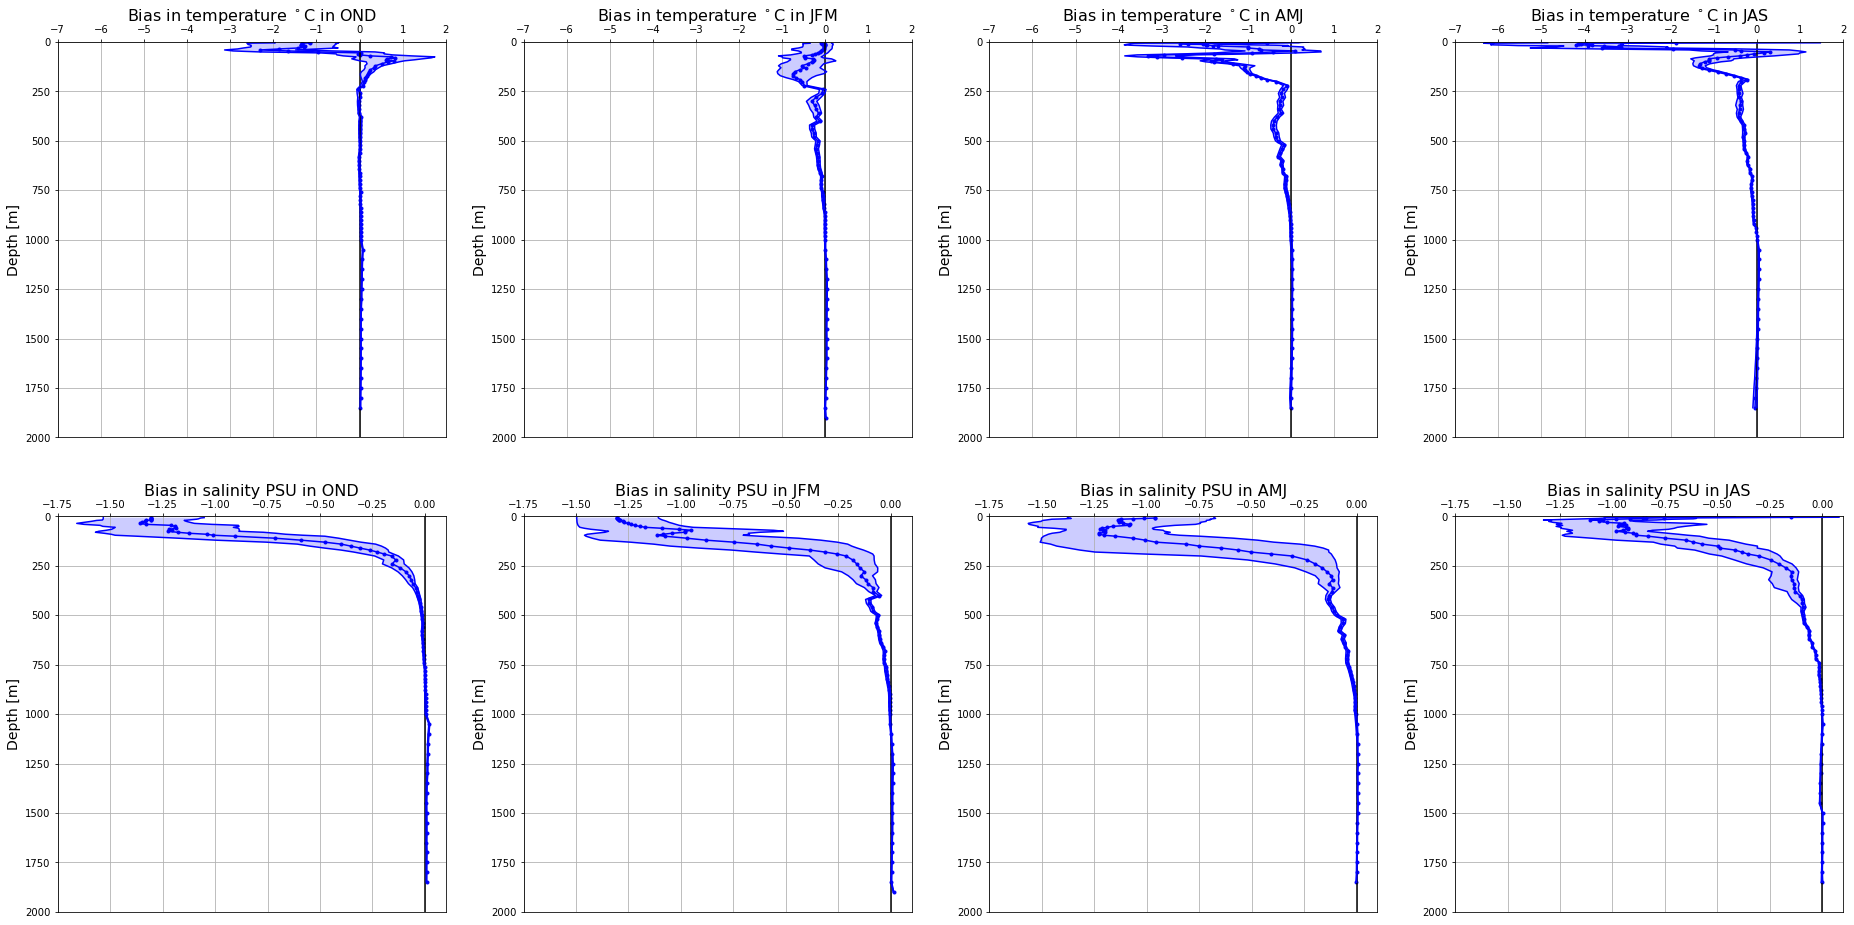

In [4]:
gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,1], height_ratios=[2,2])
fig1 = plt.figure(figsize=(32, 16))  # (w,h)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])
plot_bias_from_jsonfile('medred_autumn.json',ax1,ax2,'OND')
ax1.set_xlim(-7,2)
ax2.set_xlim(-1.75,0.1)
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax1.set_xlim(-7,2)
ax2.set_xlim(-1.75,0.1)
plot_bias_from_jsonfile('medred_winter.json',ax1,ax2,'JFM')
ax1 = plt.subplot(gs[0,2])
ax2 = plt.subplot(gs[1,2])
ax1.set_xlim(-7,2)
ax2.set_xlim(-1.75,0.1)
plot_bias_from_jsonfile('medred_spring.json',ax1,ax2,'AMJ')
ax1 = plt.subplot(gs[0,3])
ax2 = plt.subplot(gs[1,3])
ax1.set_xlim(-7,2)
ax2.set_xlim(-1.75,0.1)
plot_bias_from_jsonfile('medred_summer.json',ax1,ax2,'JAS')

plt.savefig('bias_TS_medred.png')

In [5]:
def map_profiles_from_jsonfile(jsonfile,ax1,season):
    
    print jsonfile

    sourcefile=open(jsonfile,'rU')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)

    all_lat=np.zeros((nb_profilesEN4))
    all_lon=np.zeros((nb_profilesEN4))

    def get_netcdf_profiles(jsonfile,infos,prof):
        list_profiles = infos.keys()
        reference_profile = str(list_profiles[prof])
        
        namezone=jsonfile[0:-5]
        dirname="/media/extra/DATA/EN4/profiles_files/"+namezone
        netcdf_name=dirname+"/profiles_EN4-"+reference_profile[1:]+"_NATL60-CJM165_TS.nc"
        dsprof=xr.open_dataset(netcdf_name)

        depth_en4=dsprof['depth_en4']
        lat=dsprof['latitude_profileEN4']
        lon=dsprof['longitude_profileEN4']
        
        return depth_en4,lat,lon

    for prof in np.arange(nb_profilesEN4):
        depth_en4,lat,lon = get_netcdf_profiles(jsonfile,infos,prof)
        if depth_en4[-1] > 500:
            all_lat[prof]=lat[:]
            all_lon[prof]=lon[:]

    all_lat[all_lat==0.]='nan'
    all_lon[all_lon==0.]='nan'
            
    lamin=np.nanmin(all_lat)
    lamax=np.nanmax(all_lat)
    lomin=np.nanmin(all_lon)
    lomax=np.nanmax(all_lon)
    

    my_map0 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2, 
    resolution = 'i', 
    llcrnrlon = lomin-1, llcrnrlat= lamin-1,
    urcrnrlon = lomax+1, urcrnrlat = lamax+1, area_thresh = 10)

    my_map0.drawcoastlines() 
    my_map0.drawmapboundary()
    my_map0.drawmeridians(np.arange(-120, 60, 2), labels=[1,0,0,1], size=18);
    my_map0.drawparallels(np.arange(0, 80, 2), labels=[1,0,0,1], size=18);
    my_map0.scatter(all_lon, all_lat, latlon=True, c='g', linewidth='0', s=18);
    plt.title('EN4 profiles sampled in '+season, size=20);



medred_autumn.json
medred_winter.json
medred_spring.json
medred_summer.json


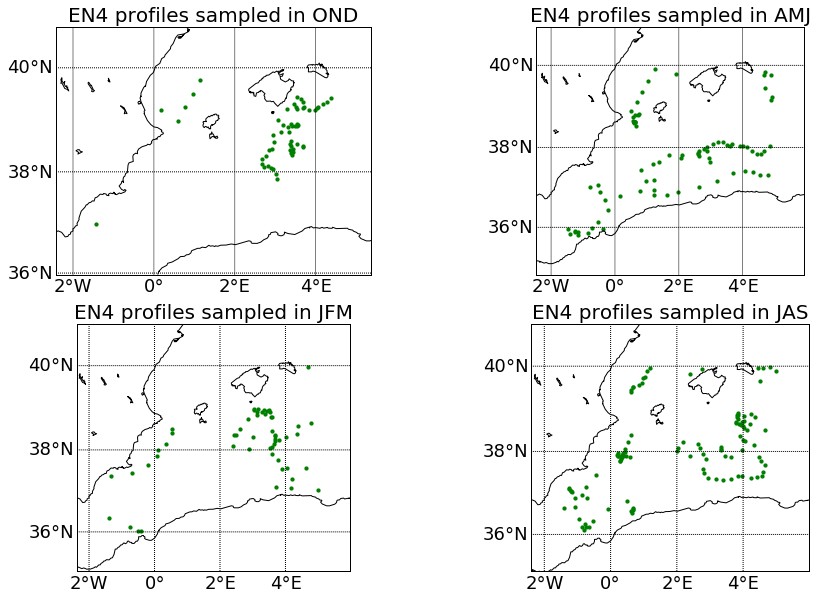

In [6]:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1])
fig1 = plt.figure(figsize=(15,10))  # (w,h)

ax1 = plt.subplot(gs[0,0])
map_profiles_from_jsonfile('medred_autumn.json',ax1,'OND')
ax1 = plt.subplot(gs[1,0])
map_profiles_from_jsonfile('medred_winter.json',ax1,'JFM')
ax1 = plt.subplot(gs[0,1])
map_profiles_from_jsonfile('medred_spring.json',ax1,'AMJ')
ax1 = plt.subplot(gs[1,1])
map_profiles_from_jsonfile('medred_summer.json',ax1,'JAS')

plt.savefig("maps_medred_seasons.png")